In [85]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [86]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-03-12-04-13']
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [87]:
# crete a dataframe from runs and summary metrics
x_metric = "planning_budget"

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

df


100%|██████████| 36/36 [00:00<00:00, 75309.20it/s]


,Evaluation/Mean_Discounted_Returns,Evaluation/Mean_Entropy,_runtime,Evaluation/Entropies,Evaluation/Mean_Returns,Evaluation/Discounted_Returns,Evaluation/Timesteps,_timestamp,Evaluation/Returns,_step,...,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform,policy_combination
0,0.000000,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.000000,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
1,0.000000,0.999595,2694.339412,"{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...",0.000000,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",1.712143e+09,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
2,0.000000,0.999713,2622.505762,"{'bins': [0.9996663928031921, 0.99966752529144...",0.000000,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.712143e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
3,0.000000,0.999202,364.093652,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",0.000000,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712141e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
4,0.020219,0.999063,254.031833,"{'_type': 'histogram', 'bins': [0.997421264648...",0.200000,"{'_type': 'histogram', 'bins': [0, 0.003026740...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.712140e+09,"{'_type': 'histogram', 'bins': [0, 0.015625, 0...",0,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
5,0.002620,0.999463,180.387694,"{'_type': 'histogram', 'bins': [0.998930633068...",0.100000,"{'_type': 'histogram', 'bins': [0, 0.000409445...","{'_type': 'histogram', 'bins': [72, 72.4375, 7...",1.712140e+09,"{'_type': 'histogram', 'bins': [0, 0.015625, 0...",0,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
6,0.000000,0.993741,53.557101,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.000000,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712140e+09,"{'bins': [-0.5, -0.484375, -0.46875, -0.453125...",0,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
7,0.009944,0.993689,46.457173,"{'_type': 'histogram', 'bins': [0.993145763874...",0.100000,"{'_type': 'histogram', 'bins': [0, 0.001553753...","{'bins': [46, 46.84375, 47.6875, 48.53125, 49....",1.712140e+09,"{'_type': 'histogram', 'bins': [0, 0.015625, 0...",0,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
8,-0.054700,0.994949,40.496958,"{'bins': [0.4949490427970886, 0.51057404279708...",-0.300000,"{'bins': [-0.2773894965648651, -0.273055285215...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...",1.712140e+09,"{'values': [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
9,0.185045,0.994078,408.505844,"{'_type': 'histogram', 'bins': [0.983401358127...",0.700000,"{'_type': 'histogram', 'bins': [0, 0.009355263...","{'bins': [11, 12.390625, 13.78125, 15.171875, ...",1.712141e+09,"{'_type': 'histogram', 'bins': [0, 0.015625, 0...",0,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT


In [88]:
def split_histogram_cols(df: pd.DataFrame) -> pd.DataFrame:
    # some columns will have dictionaries as values. The dicts will have the keys 'values', '_type', 'bins'
    # we want to split these columns into multiple columns so that each value in values is a column

    # get the columns that have dictionaries as values and that have the keys 'values', '_type', 'bins'
    hist_cols = [col for col in df.columns if isinstance(df[col].iloc[0], dict) and 'values' in df[col].iloc[0]]

    # assume that the values in the dictionaries are lists and that all lists have the same length
    # for each row, create a new row for each value in the list
    new_rows = []
    for _, row in df.iterrows():
        for i in range(len(row[hist_cols[0]]['values'])):
            new_row = row.copy()
            for col in hist_cols:

                new_col_name = "_" + col
                new_row[new_col_name] = row[col]['values'][i]
            new_rows.append(new_row)


    return pd.DataFrame(new_rows)

split_df = split_histogram_cols(df)
split_df

,Evaluation/Mean_Discounted_Returns,Evaluation/Mean_Entropy,_runtime,Evaluation/Entropies,Evaluation/Mean_Returns,Evaluation/Discounted_Returns,Evaluation/Timesteps,_timestamp,Evaluation/Returns,_step,...,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform,policy_combination,_Evaluation/Entropies,_Evaluation/Discounted_Returns,_Evaluation/Timesteps,_Evaluation/Returns
0,0.0,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,1,0,0,0
0,0.0,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
0,0.0,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
0,0.0,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
0,0.0,0.999582,5944.616206,"{'_type': 'histogram', 'bins': [0.999510943889...",0.0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [99.5, 99.51562...",1.712146e+09,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,300.0,0.248373,574.531076,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1...",300.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [299.5, 299.515...",1.712139e+09,"{'bins': [299.5, 299.515625, 299.53125, 299.54...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
35,300.0,0.248373,574.531076,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1...",300.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [299.5, 299.515...",1.712139e+09,"{'bins': [299.5, 299.515625, 299.53125, 299.54...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
35,300.0,0.248373,574.531076,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1...",300.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [299.5, 299.515...",1.712139e+09,"{'bins': [299.5, 299.515625, 299.53125, 299.54...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
35,300.0,0.248373,574.531076,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1...",300.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [299.5, 299.515...",1.712139e+09,"{'bins': [299.5, 299.515625, 299.53125, 299.54...",0,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0


In [89]:
hist_dict = df.iloc[0]["Evaluation/Discounted_Returns"]
# convert histogram to numpy array with values by mapping bins to values
hist_dict["values"]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

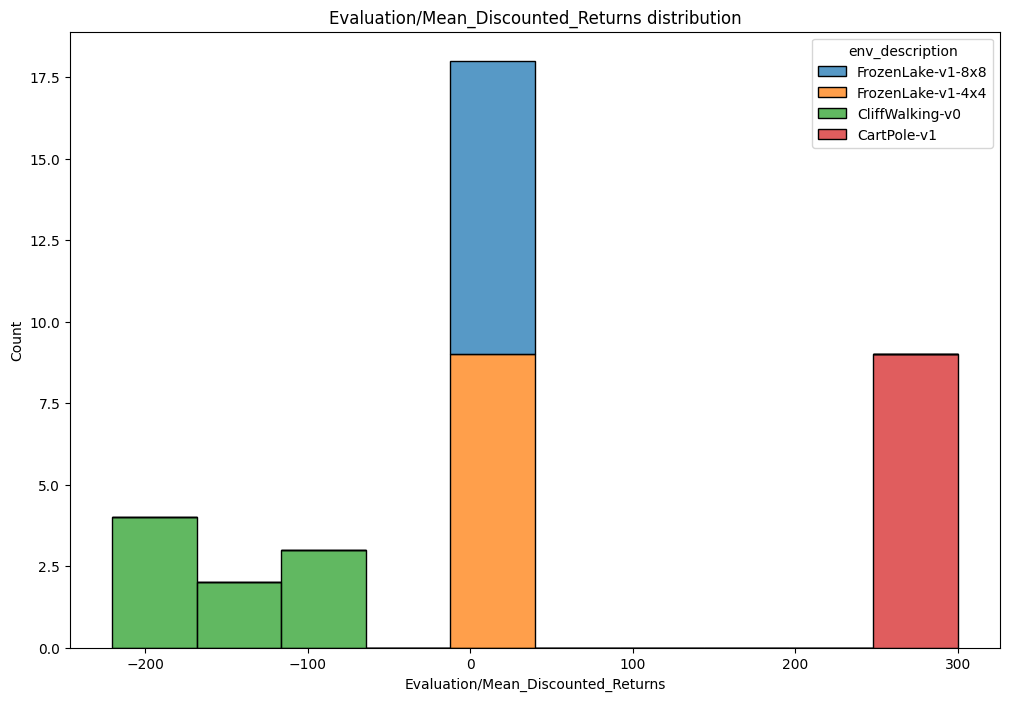

In [96]:
metrics = ['Evaluation/Mean_Discounted_Returns', 'Evaluation/Mean_Entropy', 'Evaluation/Mean_Returns']
metric = metrics[0]
challenge_col = "env_description"

# plot the distribution of metric for each "env_description" and "policy_combination"
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=df, x=metric, hue=challenge_col, multiple="stack", ax=ax)
plt.title(f"{metric} distribution")
plt.show()


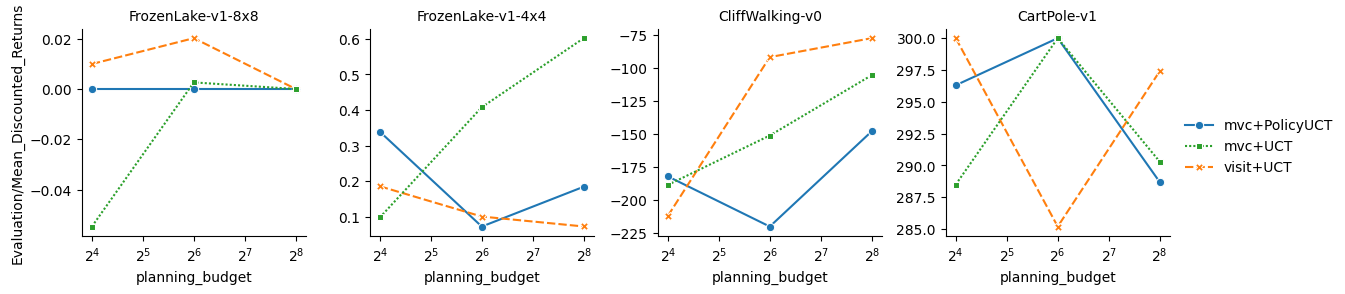

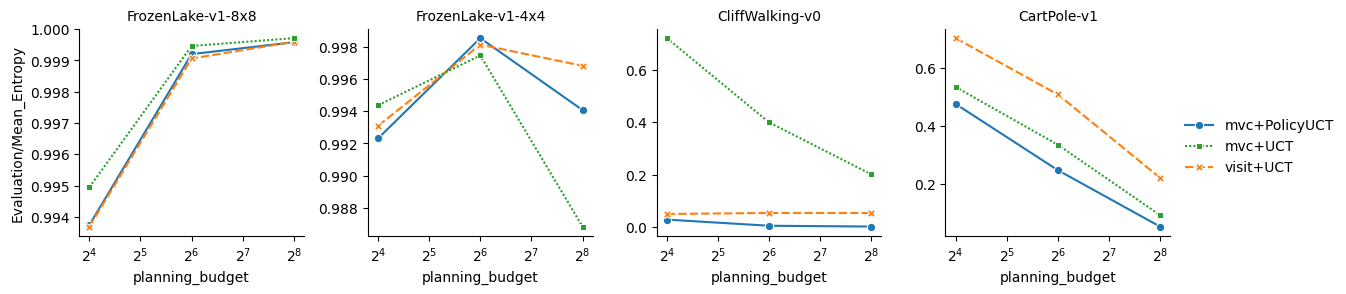

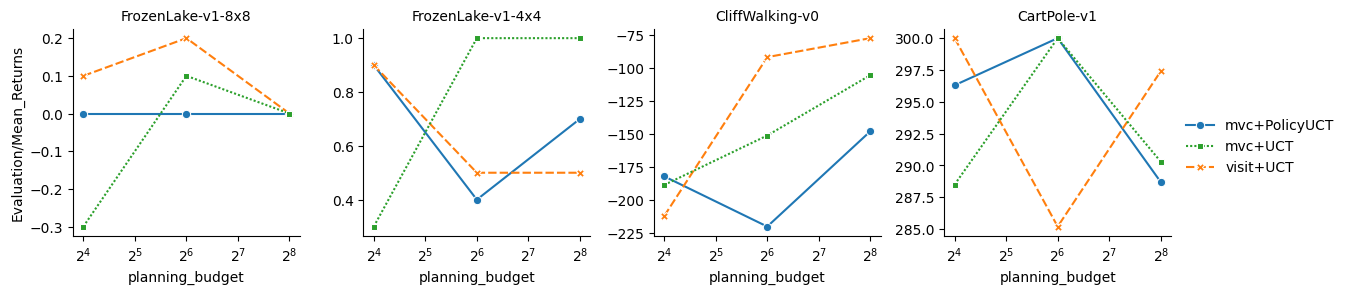

In [100]:




out_folder= "outfiles"

estimator = "mean"
for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(df, col=challenge_col,sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator=estimator)  # adjust 'estimator' as needed

    for ax in g.axes.flatten():
        ax.set_xscale('log', base=2)

    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()

    # Set the titles for each subplot for clarity
    g.set_titles("{col_name}")

    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)

    # clean metric for filename
    metric_filename = metric.replace("/", "_").replace(" ", "_").lower()

    # save pdf in out_folder
    g.savefig(f"{out_folder}/{metric_filename}_lineplot.pdf")

    plt.show()